<a href="https://colab.research.google.com/github/NathWolf/NATCOR_heuropt/blob/main/NATCOR_Challenge_4_Spark_MLlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spark MLlib Tutorial and Challenge

This notebook is based on the resources available alongside the book:

> Triguero, I., & Galar, M. (2023). **Large-Scale Data Analytics with Python and Spark: A Hands-on Guide to Implementing Machine Learning Solutions.** Cambridge: Cambridge University Press

The aim of this notebook is to play with the MLlib of Apache Spark to create a Machine Learning pipeline that preprocesses a dataset, trains a model and makes predictions. In particular, we are going to deal with a regression problem for energy consumption prediction. The content is very much inspired by the sample provided in the [databricks documentation](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/2854662143668609/2084788691983918/6837869239396014/latest.html). Throughout this notebook you will have to complete all the steps to learn from the data, ranging from loading the data and preprocessing it to learn a model and evaluate the results. To do this, we will use MLlib pipelines.

The first part of the notebook provides a Guided Tutorial, building on the MLlib example you saw in the lecture to build a pipeline and begin to investigate the data and results. There are several small tasks you will need to fill in the code for. Some parts you can complete based on the lecture example, but for others you will need to investigate the Spark SQL and MLlib documentation yourself!

The second part of the notebook provides some initial ideas for improving the results further. The challenge for you is to explore some options and see if you can improve on the model from the tutorial. This may require doing some brief study of machine learning concepts if you are unfamiliar with this area, and further exploring the functions available to you in the Spark MLlib.

# 1. Guided Tutorial

## Prediction of Energy Consumption of Home Appliances in a Low-Energy House

We are going to work with the [appliances energy prediction](http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction) dataset from the UCI Machine Learning Repository, associated to the paper by [Candanedo et al.](https://www.sciencedirect.com/science/article/pii/S0378778816308970). The objective of this dataset is to be able to predict the energy consumption of the home appliances in a low-energy house located in Belgium. The dataset contains Energy consumption from appliances at 10 minute resolution for about 4.5 months. The house temperature and humidity conditions were monitored with a wireless sensor network. Each wireless node transmitted the temperature and humidity conditions every 3.3 minutes. Then, the wireless data was averaged for 10-minute periods to match the energy consumption data. Additionally, weather data from the nearest airport weather station (Chievres Airport, Belgium) was logged.

**The task is to predict the energy consumption based on the data gathered from the wireless sensor network and the weather data.** In the original paper, they were also focused on understanding which the most relevant features were. We will also work on it.

> Although we are working with time-series data, in this case and following the original work, we will treat it as a standard regression dataset, aiming to predict the energy consumption of each point in time (every 10 minutes), just by the data taken at that same time frame.

## Set-up

The first thing we need to do to start working with Spark is to initialize the `SparkSession`. We will also import a few libraries we will use.

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("MLlib Challenge") \
    .getOrCreate()

sc = spark.sparkContext

: 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pyspark.sql.functions as sql_f # import SQL functions
from pyspark.sql import Row

# Helper function to test the correctness of the solutions
def test(var, val, msg=""):
    print("Test passed.") if var == val else print("Test failed. " + msg)

## Load and understand the data

We can download the dataset and save it as `energydata_complete.csv` by running the following cell:

In [3]:
#run in the terminal: curl -0 https://www.cs.nott.ac.uk/~pszit/data/energydata_complete.csv

Then we need to load the data, which is in Comma-Separated Value (CSV) format.

**Task:** Use `spark.read` to read the file. You should also cache the data so that we only read it from disk once.

In [4]:
#! Generate a df_origal that is not modified throughout the notebook  

# Create the dataframe
#create a df using spark.read.csv
df = spark.read.csv("energydata_complete.csv", header=True, inferSchema=True)

# Cache your DataFrame
df.cache()

24/04/09 16:17:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[date: timestamp, Appliances: double, lights: double, T1: double, RH_1: double, T2: double, RH_2: double, T3: double, RH_3: double, T4: double, RH_4: double, T5: double, RH_5: double, T6: double, RH_6: double, T7: double, RH_7: double, T8: double, RH_8: double, T9: double, RH_9: double, T_out: double, Press_mm_hg: double, RH_out: double, Windspeed: double, Visibility: double, Tdewpoint: double, rv1: double, rv2: double]

In [5]:
test(df.count(), 19735, 'Incorrect number of rows')
test(df.is_cached, True, 'df not cached')

Test passed.
Test passed.


In [21]:
# Count number of columns
print("Number of columns: ", len(df.columns))
# Count number of rows
print("Number of rows: ", df.count())

Number of columns:  32
Number of rows:  19735


**Task:** Use an appropriate method to check what columns we have in the data.

In [27]:
# Inspect the dataframe: check columns, schema, summary statistics, nulls, etc.
df.printSchema()
df.describe().show()
Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
print(Dict_Null)

root
 |-- date: timestamp (nullable = true)
 |-- Appliances: double (nullable = true)
 |-- lights: double (nullable = true)
 |-- T1: double (nullable = true)
 |-- RH_1: double (nullable = true)
 |-- T2: double (nullable = true)
 |-- RH_2: double (nullable = true)
 |-- T3: double (nullable = true)
 |-- RH_3: double (nullable = true)
 |-- T4: double (nullable = true)
 |-- RH_4: double (nullable = true)
 |-- T5: double (nullable = true)
 |-- RH_5: double (nullable = true)
 |-- T6: double (nullable = true)
 |-- RH_6: double (nullable = true)
 |-- T7: double (nullable = true)
 |-- RH_7: double (nullable = true)
 |-- T8: double (nullable = true)
 |-- RH_8: double (nullable = true)
 |-- T9: double (nullable = true)
 |-- RH_9: double (nullable = true)
 |-- T_out: double (nullable = true)
 |-- Press_mm_hg: double (nullable = true)
 |-- RH_out: double (nullable = true)
 |-- Windspeed: double (nullable = true)
 |-- Visibility: double (nullable = true)
 |-- Tdewpoint: double (nullable = true)
 |--

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+--------------------+--------------------+-----------------+------------------+-----------------+
|summary|        Appliances|            lights|                T1|              RH_1|                T2|              RH_2|                T3|              RH_3|                T4|              RH_4|                T5|             RH_5|               T6|              RH_6|                T7|             RH_7|                T8|             RH_8|                T9|             RH_9|            T_out|      

**Data description**

From the UCI repository description, we know that the columns have the following meanings:

**Attribute information**:
```
date: time year-month-day hour:minute:second
Appliances: energy use in Wh
lights: energy use of light fixtures in the house in Wh
T1: Temperature in kitchen area, in Celsius
RH_1: Humidity in kitchen area, in %
T2: Temperature in living room area, in Celsius
RH_2: Humidity in living room area, in %
T3: Temperature in laundry room area
RH_3: Humidity in laundry room area, in %
T4: Temperature in office room, in Celsius
RH_4: Humidity in office room, in %
T5: Temperature in bathroom, in Celsius
RH_5: Humidity in bathroom, in %
T6: Temperature outside the building (north side), in Celsius
RH_6: Humidity outside the building (north side), in %
T7: Temperature in ironing room , in Celsius
RH_7: Humidity in ironing room, in %
T8: Temperature in teenager room 2, in Celsius
RH_8: Humidity in teenager room 2, in %
T9: Temperature in parents room, in Celsius
RH_9: Humidity in parents room, in %
To: Temperature outside (from Chievres weather station), in Celsius
Pressure: (from Chievres weather station), in mm Hg
RH_out: Humidity outside (from Chievres weather station), in %
Wind speed: (from Chievres weather station), in m/s
Visibility: (from Chievres weather station), in km
Tdewpoint: (from Chievres weather station), Â°C
rv1: Random variable 1, nondimensional
rv2: Random variable 2, nondimensional
```

**The target variable is the energy use of the Appliances.**

For now, we will leave the two variables `rv1` and `rv2` in our dataset, to see if they are affecting our methods much, then we can try to remove them and see if we improve the results.

**Task:** Use `show` to visualize the data. Be careful not to show the entire data frame, only 5 rows!

In [7]:
df.show(5)

+-------------------+----------+------+-----+----------------+----+----------------+-----+----------------+----------------+----------------+----------------+-----+----------------+----------------+----------------+----------------+----+----------------+----------------+-----+----------------+-----------+------+----------------+----------------+---------+------------------+------------------+
|               date|Appliances|lights|   T1|            RH_1|  T2|            RH_2|   T3|            RH_3|              T4|            RH_4|              T5| RH_5|              T6|            RH_6|              T7|            RH_7|  T8|            RH_8|              T9| RH_9|           T_out|Press_mm_hg|RH_out|       Windspeed|      Visibility|Tdewpoint|               rv1|               rv2|
+-------------------+----------+------+-----+----------------+----+----------------+-----+----------------+----------------+----------------+----------------+-----+----------------+----------------+----------

## Data preprocessing

This dataset is nicely prepared for Machine Learning and required very little preprocessing. However, rather than keeping the date as a timestamp, we would like to have some additional columns, including 'day of the year', 'hour', and 'month of the year'.

**Task:** Use `.withColumn()` and other appropriate functions to add the three additional columns. Please use the naming `dayofyear`, `hour` and `month`, respectively.

*Hint: Of course the SparkSQL library has functions to transform strings with datetime! You may find the [documentation](https://spark.apache.org/docs/3.1.2/api/python/reference/pyspark.sql.html#functions) useful to explore to find specific functions.*

Would you like to have any other information from the datetime? Feel free to add other features.

In [35]:
from pyspark.sql.functions import col, to_timestamp, dayofyear, hour, month, date_format

# Cast the 'date' column to a timestamp type
df = df.withColumn('date', to_timestamp(col('date'), 'yyyy-MM-dd HH:mm:ss'))
df = df.withColumn("date", date_format("date", "yyyy-MM-dd HH:mm:ss"))

# Recalculate the columns based on the 'date' column
df = df.withColumn("dayofyear", dayofyear(col('date')))
df = df.withColumn("hour", hour(col('date')))
df = df.withColumn("month", month(col('date')))

In [36]:
# Print the head of the columns 'date', 'dayofyear', 'hour', 'month'
df.select('date', 'dayofyear', 'hour', 'month').show(5)
df.select('dayofyear', 'hour', 'month', 'date').first()

+-------------------+---------+----+-----+
|               date|dayofyear|hour|month|
+-------------------+---------+----+-----+
|2016-01-11 17:00:00|       11|  17|    1|
|2016-01-11 17:10:00|       11|  17|    1|
|2016-01-11 17:20:00|       11|  17|    1|
|2016-01-11 17:30:00|       11|  17|    1|
|2016-01-11 17:40:00|       11|  17|    1|
+-------------------+---------+----+-----+
only showing top 5 rows



Row(dayofyear=11, hour=17, month=1, date='2016-01-11 17:00:00')

In [37]:
test("hour" in df.columns, True, "The hour hasn't been added")
test("dayofyear" in df.columns, True, "The dayofyear hasn't been added")
test("month" in df.columns, True, "The month hasn't been added")
test(df.select('dayofyear', 'hour', 'month', 'date').first(), (11, 17, 1, '2016-01-11 17:00:00'))

Test passed.
Test passed.
Test passed.
Test passed.


**Task:** When your dataframe `df` has the additional columns, please remove the column `date`:

In [38]:
# Remove column data from the dataframe
df = df.drop("date")

In [39]:
test("date" in df.columns, False, "Column date has not been removed!")

Test passed.


Let's look again at the schema of the dataframe:

In [40]:
df.printSchema()

root
 |-- Appliances: double (nullable = true)
 |-- lights: double (nullable = true)
 |-- T1: double (nullable = true)
 |-- RH_1: double (nullable = true)
 |-- T2: double (nullable = true)
 |-- RH_2: double (nullable = true)
 |-- T3: double (nullable = true)
 |-- RH_3: double (nullable = true)
 |-- T4: double (nullable = true)
 |-- RH_4: double (nullable = true)
 |-- T5: double (nullable = true)
 |-- RH_5: double (nullable = true)
 |-- T6: double (nullable = true)
 |-- RH_6: double (nullable = true)
 |-- T7: double (nullable = true)
 |-- RH_7: double (nullable = true)
 |-- T8: double (nullable = true)
 |-- RH_8: double (nullable = true)
 |-- T9: double (nullable = true)
 |-- RH_9: double (nullable = true)
 |-- T_out: double (nullable = true)
 |-- Press_mm_hg: double (nullable = true)
 |-- RH_out: double (nullable = true)
 |-- Windspeed: double (nullable = true)
 |-- Visibility: double (nullable = true)
 |-- Tdewpoint: double (nullable = true)
 |-- rv1: double (nullable = true)
 |-- rv2

Oh, no! All the input features have been inferred as strings rather than numeric values.

**Task:** Transform that into numerical values. All of the features are actually numeric, so you could cast all of them. You are recommended to use functions like `cast` and `col` to do this. You could try to leave out the datetime columns we created, but it's fine if you transform them to float.

In [47]:
# Change the column type from string to numeric
from pyspark.sql.types import FloatType

for col in df.columns:
    if col != 'date':
        df = df.withColumn(col, df[col].cast(FloatType()))

In [48]:
# Print the schema again.
df.printSchema()

root
 |-- Appliances: float (nullable = true)
 |-- lights: float (nullable = true)
 |-- T1: float (nullable = true)
 |-- RH_1: float (nullable = true)
 |-- T2: float (nullable = true)
 |-- RH_2: float (nullable = true)
 |-- T3: float (nullable = true)
 |-- RH_3: float (nullable = true)
 |-- T4: float (nullable = true)
 |-- RH_4: float (nullable = true)
 |-- T5: float (nullable = true)
 |-- RH_5: float (nullable = true)
 |-- T6: float (nullable = true)
 |-- RH_6: float (nullable = true)
 |-- T7: float (nullable = true)
 |-- RH_7: float (nullable = true)
 |-- T8: float (nullable = true)
 |-- RH_8: float (nullable = true)
 |-- T9: float (nullable = true)
 |-- RH_9: float (nullable = true)
 |-- T_out: float (nullable = true)
 |-- Press_mm_hg: float (nullable = true)
 |-- RH_out: float (nullable = true)
 |-- Windspeed: float (nullable = true)
 |-- Visibility: float (nullable = true)
 |-- Tdewpoint: float (nullable = true)
 |-- rv1: float (nullable = true)
 |-- rv2: float (nullable = true)
 

In [49]:
from pyspark.sql.types import FloatType
for c in df.columns:
    if c not in ['dayofyear', 'month', 'hour']:
        test(df.schema[c].dataType, FloatType(), 'Incorrect data type for ' + c)

Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.
Test passed.


## Split data into training and test sets

As a simple means to validate the results of the model we are going to build, we split the dataset into training and test sets. We will train and tune our model on the training set, and then see how well we do in the test.

> Although in some time-series problems it is key to perform the appropriate train-test split considering the temporal component (e.g., [TimeSeriesSplit from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit), in our case we follow the procedure of the original paper where the interest lies in working with each data point independently, and hence, we can proceed with a standard random split.

**Task:** Split the dataframe `df` into 70% for training (`df_train`) and 30% for test (`df_test`). You should fix a random seed.

In [50]:
# Fix a random seed for reproducibility
seed = 42 # the secret of the universe

# Split the data into training and test sets (70% training, 30% test)
df_train, df_test = df.randomSplit([0.7, 0.3], seed=seed)

> Even though we have fixed the random seed, you will not always get the exact same split. Different computers with different operating systems may provide different splits with Spark.

Note that this is the simplest way of validating your results. You may want to carry out a [k-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) and split the dataset into *k* folds, and build and test *k* models. We will do later cross validation but for parameter tuning! Not to validate our approach!

## Data visualisation

Before applying any machine learning algorithm, it is a good practice to try to visualise your data. For example, we could see how much energy is spent in appliances depending on the month.

We first group the dataframe by the `month` column, before summing together the values in the `Appliances` column for each group.

In [51]:
# create a variable `hist_elect` that contains the histogram of total energy consumed by the Appliances, grouped by month
hist_elect = df_train.groupBy('month').sum('Appliances').sort("month").collect()

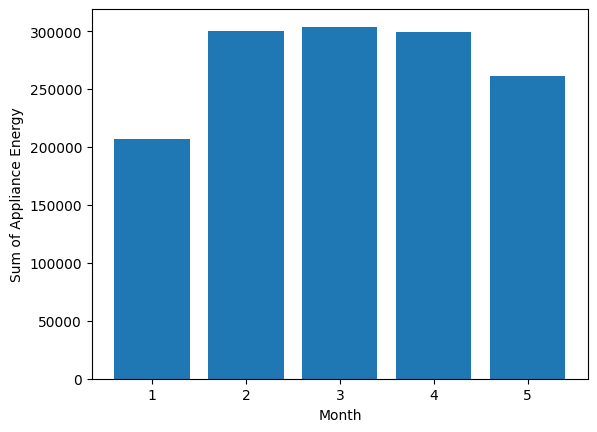

In [52]:
(x_values, y_values) = zip(*hist_elect)
plt.bar(x_values, y_values)
plt.xlabel('Month')
plt.ylabel('Sum of Appliance Energy')
plt.show()

Surprisingly, we don't seem to have all the data from the 1st of January as we have less consumption in that particular month.

**Task:** Check the number of data points we have for each month. You will need to use `groupBy()` and an appropriate aggregation to get the number of data points for each group. You may wish to refer to the [Spark SQL Grouping documentation](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/grouping.html).


In [53]:
from pyspark.sql.functions import count

# Group the data by 'month' and count the number of records in each group
month_counts = df_train.groupBy('month').agg(count('*').alias('num_records'))

# Show the counts for each month
month_counts.show()

+-----+-----------+
|month|num_records|
+-----+-----------+
|  2.0|       2952|
|  1.0|       2124|
|  3.0|       3122|
|  4.0|       3064|
|  5.0|       2725|
+-----+-----------+



We have fewer examples for both January and May. So probably the month is not a good feature, don't you think?

Even if we did have the same number of examples for those months, it wouldn't make much sense to use it if we expect our model to predict future values in other months different than those. We are going to remove it from the DataFrame (and the training and test data frames too!).

**Task:** Remove the `month` column from `df`, `df_train` and `df_test`.

In [54]:
# Update the variables `df`, `df_train` and `df_test`, removing the column 'month'
df = df.drop('month')
df_train = df_train.drop('month')
df_test = df_test.drop('month')

#! This analysis and latter update of the data should have been done before splitting the data into training and test sets. 

In [55]:
test("month" in df.columns, False, "Column month has not been removed!")
test("month" in df_train.columns, False, "Column month has not been removed!")
test("month" in df_test.columns, False, "Column month has not been removed!")

Test passed.
Test passed.
Test passed.


You could do other plots to understand better the data and practice with Spark. This is a good opportunity to practice with the DataFrame API!

**Task:** Add any other analysis of the data you consider necessary in the cell below.

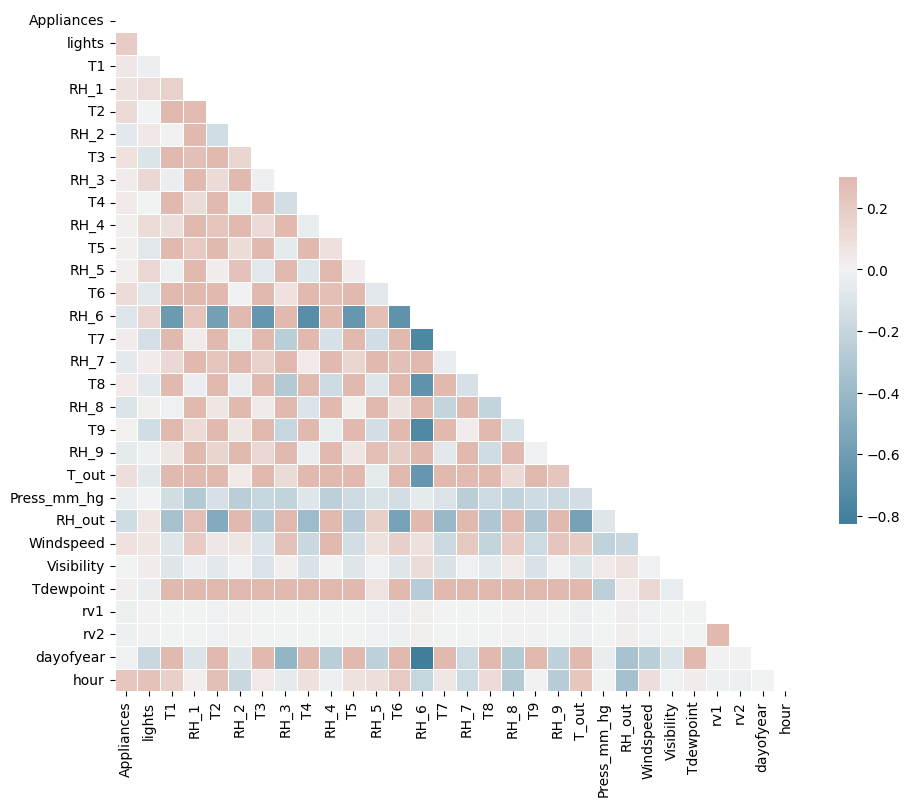

In [62]:
# Plot a correlation matrix of the features in the training set
import seaborn as sns
import numpy as np 

corr = df_train.toPandas().corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

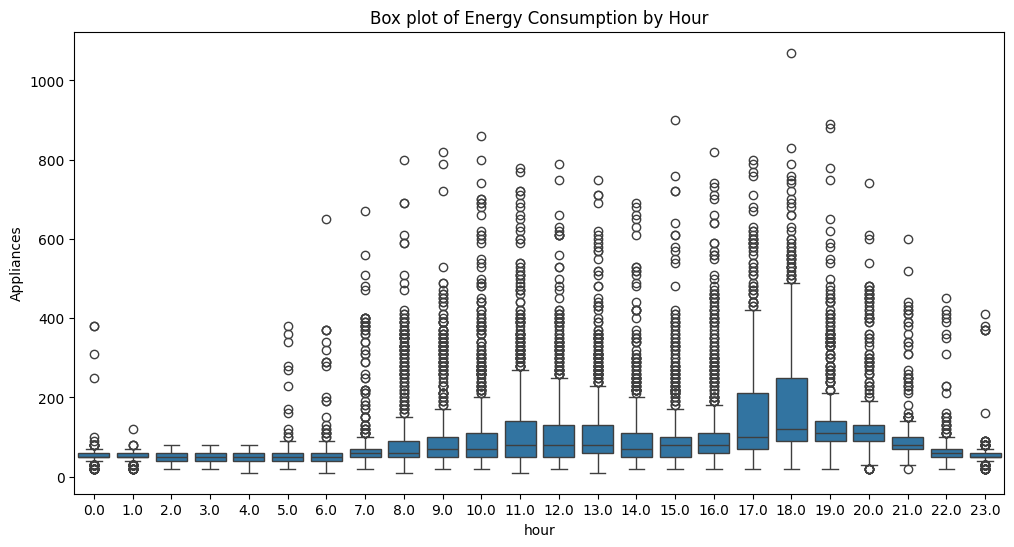

In [64]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = df_train.select('hour', 'Appliances').toPandas()

# Create a box plot for energy consumption by hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='Appliances', data=pandas_df)
plt.title('Box plot of Energy Consumption by Hour')

plt.show()

## Create a Pipeline with Spark ML

As you know, we can't feed the DataFrame directly to a machine learning algorithm, as we need to put all the input features as an Array, and indicate which one is the output feature (in our case, the 'Appliances' column!).

We will put together a simple Pipeline with the following stages:

- VectorAssembler: To combine all the input columns into a single vector column (i.e., all the columns but the 'Appliances' one.
- Learning algorithm: We feel like using Gradient-Boosted Trees [GBTs](https://en.wikipedia.org/wiki/Gradient_boosting) for this example, but feel free to use anything else.
- CrossValidator: We will use cross validation to tune the parameters of the GBT model. Yes, this can be added as part of a pipeline!

**Task:** Create the `VectorAssembler`. Do not forget to remove the target variable from the input columns!

In [79]:
from pyspark.ml.feature import VectorAssembler

input_cols = [col for col in df_train.columns if col != 'Appliances']

# Check if 'features' column already exists
if 'features' not in df_train.columns:
    assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
    # Transform the data by combining features
    df_train = assembler.transform(df_train)
else:
    print("The column 'features' already exists.")

The column 'features' already exists.


**Task:** Create an instance of `GBTRegressor` in which you don't indicate any parameters other than the target variable (i.e. `labelCol`), which should be set to `Appliances`. Assign it to a variable named `gbt`.

In [69]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(labelCol='Appliances')

**Task:** Create a `CrossValidator` for `gbt`. You will first need to create a parameter grid and evaluator. The following cells guide you through these steps.

You can explore the hyper-parameters you like for GBTs. Full documentation [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.GBTRegressor.html). We would suggest to create a 'grid' for at least the depth of the tree and the number of iterations (e.g., we started with 10 and 20 iterations and the maximum depth at 5 and 8). If you are using your own computer, perhaps it is not a good idea to investigate more than 4-8 combinations of parameters.

Use `ParamGridBuilder()` to create your parameter grid. Check the docs for how to use it!

In [70]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

# Create a ParamGridBuilder and build the grid
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 8])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

Create a `RegressionEvaluator`
 that uses the [Root Mean Squared Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) as our performance metric.

In [71]:
from pyspark.ml.evaluation import RegressionEvaluator

# Create a variable `evaluator` with a rmse as metric for the prediction column given by `gbt`.
evaluator = RegressionEvaluator(labelCol='Appliances', predictionCol='prediction', metricName='rmse')

We can now create a CrossValidator `cv` that uses the `gbt` as estimator, as well as the evaluator and grid we defined above.

In [72]:
# Create a CrossValidator `cv` that uses the `gbt` as estimator, as well as the evaluator and grid we defined above.
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

Now we can put everything together into a Pipeline.

**Task:** Create a Pipeline (`pipeline`) that contains the two stages, `vectorAssembler` and `cv`.

In [76]:
from pyspark.ml import Pipeline

# Create a Pipeline (`pipeline`) that contains the two stages, `vectorAssembler` and `cv`.
pipeline = Pipeline(stages=[cv])

We are finally ready to fit our pipeline to the training data.

**Task:** `fit` the model, and store in a `pipeline_model` variable. This might take quite a bit of time!

In [78]:
# `fit` the model, and store in a `pipeline_model` variable.
pipeline_model = pipeline.fit(df_train)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/Users/nathalia/git/NATCOR_heuropt/NATCOR/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/nathalia/git/NATCOR_heuropt/NATCOR/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Users/nathalia/miniforge3/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

**Task:** It could be a good idea to save the `pipelineModel` to disk, in case it takes too long, so we can read it later and re-use it. You should explore the [Pipeline API](https://spark.apache.org/docs/3.3.0/api/python/reference/api/pyspark.ml.PipelineModel.html#pyspark.ml.PipelineModel) to find out how to do this.

In [ ]:
# <FILL-IN WITH YOUR CODE>

## Evaluate the results

To obtain the predictions in the test set, apply the method `transform()` of the trained pipeline on the test DataFrame! This step will not apply the cross-validation, it will simply use the best model from the training stage.

**Task:** Use `pipeline_model` to transform the test set, and store the resulting predictions in a variable called `predictions`.

In [ ]:
# create a variable `predictions`:

# <FILL-IN WITH YOUR CODE>

It is easier to view the results when we limit the columns displayed to:

- `Appliances`: the consumption of the Appliances in Wh
- `prediction`: our predicted consumption

**Task:** Find a way to show the output  with these two features only (and only for the first 5 rows):

In [ ]:
# <FILL-IN WITH YOUR CODE>

Are these results any good? Let's compute the RMSE using the evaluator we created before!

**Task:** Use `evaluator` to get the RMSE of the predictions from our `pipeline_model`. Store the result in a `rmse` variable.

In [ ]:
# <FILL-IN WITH YOUR CODE>

In [ ]:
print(rmse)

Seems a bit high?  Well, this number is relatively close to what it is reported in the original paper with RandomForest (RMSE around 69). But maybe you can investigate a bit more if you can improve that. Can we find out the importance of the features from the GBTs?  

We first need to find out the best model!! In the way we trained the pipeline, you can find the trained model as one of the stages of the `pipeline_model`.

In [ ]:
cv_model = pipeline_model.stages[1]

In [ ]:
cv_model.bestModel

We can access the feature importances for the `cv_model.bestModel` as shown in the following cell.

In [ ]:
importance = cv_model.bestModel.featureImportances
list(sorted(zip(featuresCols, importance.toArray()), key=lambda t: -t[1]))

Uhm, looks like our model gave the hour of the day (feature #28) quite a bit of importance. The random features ('rv1' and 'rv2', numbered, #25 and #26) were given different importance. While the model noticed that 'rv2' was completely useless, it gave some importance to 'rv1'.

GBTs perform somehow an implicit feature selection, so those low-importance features won't affect much their performance, but we wonder if we could just remove low-importance features?

## Removing low-importance features

**Task:** Create a list of those features with importance less than 0.05. Your list should be called `to_remove`.

In [ ]:
# create a list `to_remove` that contains the feature names that must be removed because their confidence is less than 0.05

# <FILL-IN WITH YOUR CODE>

In [ ]:
print(to_remove)

Check the current schema of the training data:

In [ ]:
df_train.printSchema()

**Task:** Create a new VectorAssembler (called `vectorAssembler2`) with the low-importance columns removed.

You don't need to remove the columns from the train and test dataframes as you won't be able to re-train the pipeline without modifying the `VectorAssembler`. You simply need to indicate the columns you want to use when creating a new `vectorAssembler2`

In [ ]:
# <FILL-IN WITH YOUR CODE>

**Task:** Create a new pipeline, `pipeline2`, with that new `vectorAssembler2`, and fit it to the training data. Use the resulting pipeline model to make predictions on the test set, and then compute the RMSE.

In [ ]:
# <FILL-IN WITH YOUR CODE>

In [ ]:
# <FILL-IN WITH YOUR CODE>

**Task:** Check the features and feature importances of the best model.

In [ ]:
# Check the number of features used by the best model

# <FILL-IN WITH YOUR CODE>

In [ ]:
# Check the feature importances

# <FILL-IN WITH YOUR CODE>

In this case, you will probably get less performance than before (will depend on your training and test partitions), but this time our model considered much fewer features! This might not have made our model more precise (because GBTs already ignored those features), but makes it more interpretable!

# 2. Challenge: Improve the model further

You have now seen how to construct a simple pipeline using Spark MLlib, and begun to investigate the results you achieved with the `GBTRegressor`.

There might be many ways to improve on the results we obtained here. We provide below some ideas for you to think about, categorised by whether they relate to the data preprocessing/preparation or the regression model itself. You are welcome to explore other options instead of our suggestions if you would like!

**Data preparation**:
- We haven't really done any careful pre-processing of the data. Are there outliers or noise that might be having an impact on the results?
- Do we need any normalization?
- You can still try with different subsets of features. We recommend you to take a look at the original paper and borrow some ideas to improve.

**Regression model**:
- Hyper-parameter tuning: We have used a relatively small set of parameters, and we haven't investigated what happened in training and test sets; Is there overfitting of the training set? Would we be able to use a larger number of trees?
- The features of this dataset are numerical, are there other regression models that may be more appropriate than GBTs?

### Minimum expectations for the challenge

You should investigate *at least one* aspect from the data preparation stage and *at least one* aspect of the regression model for improving the results. You will need to implement the appropriate pipelines in Spark MLlib to achieve this.

You will also need to evaluate the success of your new pipelines, and compare their results. In the tutorial above we only used RMSE, you can consider using additional metrics as well if you would like.
